In [8]:
from astropy.io import fits
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.colors import LogNorm
from numpy import pi, cos,sin
import os
import re
import urllib.request
D_003=132.2 # luminsity distance for z=0.03 this can also come from astropy
folderdata='/scratch/garzilli/data/'
folderobj = os.path.join(folderdata,'dr16/eboss/photoObj/301/')

# MODE=1 # only primary
MODE=2 # only secondary

In [2]:
# Here is the source of interest as an example: 

#Mrk 421
#RA_s=166.113808
#DEC_s=38.208833	
#z_s=0.03


#R_s=z_s*D_003/0.03
#X_s=R_s*cos(DEC_s*pi/180.)
#H_s=0.
#H_s=R_s*sin(DEC_s*pi/180.)radius=0.1 # in gradi

#ra_in = 94.929341
#dec_in = 2.488812
# source
ra_in  = 17
dec_in = -3.38
source = SkyCoord(ra_in,dec_in, unit='deg')
radius = 100 # in arcmin

In [3]:
ra     = np.array([])
raMin  = np.array([])
raMax  = np.array([])
dec    = np.array([])
decMin = np.array([])
decMax = np.array([])
field  = np.array([], dtype='int')
camcol = np.array([], dtype='int')
run    = np.array([], dtype='int')

for dd in os.listdir(folderobj):
    for ff in os.listdir(os.path.join(folderobj, dd)):
        if re.search('photoField',ff):
            ffull=os.path.join(folderobj,os.path.join(dd,ff))
            with fits.open(ffull) as hdu:
                ra     = np.append(ra, np.copy(hdu[1].data['RA']))
                raMin  = np.append(raMin, np.copy(hdu[1].data['raMin']))
                raMax  = np.append(raMax, np.copy(hdu[1].data['raMax']))
                dec    = np.append(dec, np.copy(hdu[1].data['dec']))
                decMin = np.append(decMin, np.copy(hdu[1].data['decMin']))
                decMax = np.append(decMax, np.copy(hdu[1].data['decMin']))
                field  = np.append(field, np.copy(hdu[1].data['field']))
                camcol = np.append(camcol, np.copy(hdu[1].data['camcol']))
                run    = np.append(run, np.copy(hdu[1].data['run']))

ci = SkyCoord(ra, dec, unit='deg')
sep=source.separation(ci)

indexFrame = np.where(sep.arcmin<radius)[0]
#print(indexFrame)
par = []
for ii in indexFrame:
    par.append({'field':field[ii],'camcol':camcol[ii],'run':run[ii],
                   'ra':ra[ii], 'dec':dec[ii],
                    'raMin':raMin[ii], 'decMin':decMin[ii],
                    'raMax':raMax[ii], 'decMax':decMax[ii]}) 
#print(par)

for ii, p in enumerate(par):
    folderff = os.path.join(os.path.join(folderobj,'{:d}'.format(p['run'])),'{:d}'.format(p['camcol']))
    ff = (r'photoObj-'+'{:06d}'.format(p['run'])+r'-'+'{:d}'.format(p['camcol'])+
          r'-'+'{:04d}'.format(p['field'])+r'.fits')
    par[ii]['photoObj_path'] = os.path.join(folderff,ff)


In [4]:
# with fits.open(os.path.join(folderdata,'photoRunAll-dr16.fits')) as hdu:
#     ra_all  = hdu[1].data['NODE']
#     dec_all = hdu[1].data['INCL']
#     dec_all[np.where((dec_all>90))[0]]=90
#     c_all   = SkyCoord(ra_all,dec_all, unit='deg')
#     sep_all = source.separation(c_all)
#     index   = np.where(sep_all.arcmin<1000)
    
#     run_all = hdu[1].data['run'][index]
#     #lF_all  = hdu[1].data['lastField'][index]
#     print(run_all)
#     print(index)



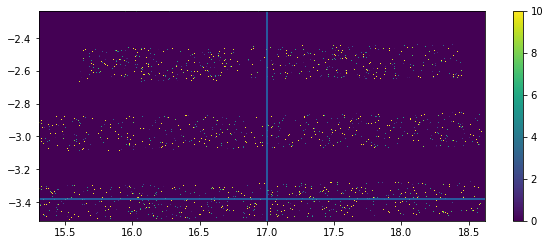

In [5]:
RA_plot      = np.array([])
DEC_plot     = np.array([])
PSFFLUX_plot = np.array([])
# this can give problems on the borders
ra_min       = np.inf
ra_max       = -np.inf
dec_min      = np.inf
dec_max      = -np.inf
for i,p in enumerate(par):
    ff=p['photoObj_path']
    with fits.open(ff) as hdul:
        #print(hdul.info())
        cat          = hdul[1].data
        mode         = np.copy(cat['MODE'])
        j = np.where(mode==MODE)
        RAi          = np.copy(cat['RA'])[j]
        DECi         = np.copy(cat['DEC'])[j]
        PSFFLUXi     = np.copy(cat['PSFFLUX'])[j]
        RA_plot      = np.append(RAi, RA_plot)
        DEC_plot     = np.append(DECi, DEC_plot)
        ra_min       = np.min([ra_min,p['raMin']])
        ra_max       = np.max([ra_max,p['raMax']])
        dec_min       = np.min([dec_min,p['decMin']])
        dec_max       = np.max([dec_max,p['decMax']])
        
        if i==0:
            PSFFLUX_plot = PSFFLUXi
        else:
            PSFFLUX_plot = np.concatenate((PSFFLUXi, PSFFLUX_plot))



# ra_min   = np.amin([np.amin(RA_plot),ra_in])
# ra_max   = np.amax([np.amax(RA_plot),ra_in])
# print(ra_min)
# print(ra_max)
# dec_min  = np.amin(DEC_plot)
# dec_max  = np.amax(DEC_plot)
pix_size = 1/60./10. # say, one arcmin
dec_mid  = (dec_min + dec_max) / 2.
Nra      = int((ra_max - ra_min) * cos(dec_mid * pi / 180.) / pix_size)
Ndec     = int((dec_max - dec_min) / pix_size)
ra_b     = np.linspace(ra_min, ra_max, Nra)
dec_b    = np.linspace(dec_min, dec_max, Ndec)


fig = plt.figure(figsize=(10.,10.*(Ndec / Nra)))
plt.hist2d(RA_plot, DEC_plot, bins=([ra_b, dec_b]), weights=PSFFLUX_plot[:,4], vmax=10, vmin=0)
plt.colorbar()
plt.axhline(dec_in)
plt.axvline(ra_in)
#plt.xlim(RA_s-0.1,RA_s+0.1)
#plt.ylim(DEC_s-0.1,DEC_s+0.1)


In [26]:
with urllib.request.urlopen('http://simbad.u-strasbg.fr/simbad/sim-script?script=M31') as response:
   html = response.read().decode("utf-8")
#print(html)
ll=html.split('\n')
for line in ll:
    if re.search("coord",line):
        lline = line.split(' : ')[1]
        line1 = lline.split('+')[0]
        line2 = lline.split('+')[1]
        ra_deg = line1.split()[0]
        ra_min = line1.split()[1]
        ra_sec = line1.split()[2]
        dec_deg = line2.split()[0]
        dec_min = line2.split()[1]
        dec_sec = line2.split()[2]
        ra_angle  = ra_deg  + '°' + ra_min  + '′' + ra_sec + '″'
        dec_angle = dec_deg + '°' + dec_min + '′' + dec_sec + '″'
        
        print(line)
        print(ra_angle)
        print(dec_angle)
        print('in arcmin')
        print(Angle(ra_angle).arcmin)
        print(Angle(dec_angle).arcmin)
        print('in degree')
        print(Angle(ra_angle).degree)
        print(Angle(dec_angle).degree)

coord : 00 42 44.330+41 16 07.50 (IR  ) [~ ~ ] C 2006AJ....131.1163S
00°42′44.330″
41°16′07.50″
in arcmin
42.738833333333325
2476.125
in degree
0.7123138888888888
41.26875
